In [26]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = yf.download('SPY', start='2018-01-01', end='2023-01-01')
data.to_csv('spy_data.csv')  # save locally for backup
print(data.head())

[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume
Ticker             SPY         SPY         SPY         SPY       SPY
Date                                                                
2018-01-02  239.273987  239.309605  238.054341  238.446056  86655700
2018-01-03  240.787384  240.938739  239.443090  239.443090  90070400
2018-01-04  241.802307  242.291964  240.849754  241.437326  80636400
2018-01-05  243.413666  243.538287  242.104989  242.603530  83524000
2018-01-08  243.858795  244.019035  243.021953  243.315725  57319200


Signal counts:
Signal
1    766
0    493
Name: count, dtype: int64
Price            Close   SMA_short    SMA_long Signal Position
Ticker             SPY                                        
Date                                                          
2022-12-02  392.751373  388.612598  386.890674      1      0.0
2022-12-05  385.686066  389.322980  387.234290      1      0.0
2022-12-06  380.126495  389.052716  387.160928      1      0.0
2022-12-07  379.479828  386.249762  386.510379      0     -1.0
2022-12-08  382.452606  384.099274  385.913873      0      0.0
2022-12-09  379.595642  381.468127  385.040363      0      0.0
2022-12-12  385.068359  381.344586  385.333783      0      0.0
2022-12-13  387.983246  382.915936  385.984326      0      0.0
2022-12-14  385.502686  384.120508  385.185135      0      0.0
2022-12-15  376.072601  382.844507  383.471890      0      0.0
2022-12-16  371.632660  381.251910  381.360019      0      0.0
2022-12-19  368.481354  377.934509  379.639548      

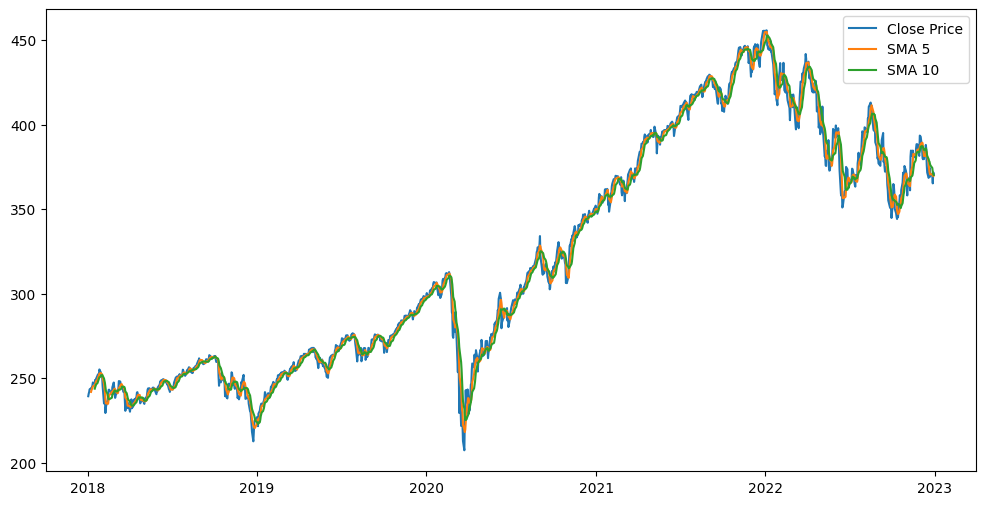

In [27]:
# Step 2: Calculate SMAs with smaller windows for more crossovers
data['SMA_short'] = data['Close'].rolling(window=5).mean()
data['SMA_long'] = data['Close'].rolling(window=10).mean()

# Generate signals
data['Signal'] = 0
data.loc[data['SMA_short'] > data['SMA_long'], 'Signal'] = 1

# Calculate position changes (buy=1, sell=-1)
data['Position'] = data['Signal'].diff()

# Check signal distribution
print("Signal counts:")
print(data['Signal'].value_counts())

# Print last 20 rows to see signals and positions
print(data[['Close', 'SMA_short', 'SMA_long', 'Signal', 'Position']].tail(20))

# Optional: Save to CSV for inspection
data.to_csv('spy_sma_signals.csv')

# Optional: Plot to visualize crossovers
plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='Close Price')
plt.plot(data['SMA_short'], label='SMA 5')
plt.plot(data['SMA_long'], label='SMA 10')
plt.legend()
plt.show()

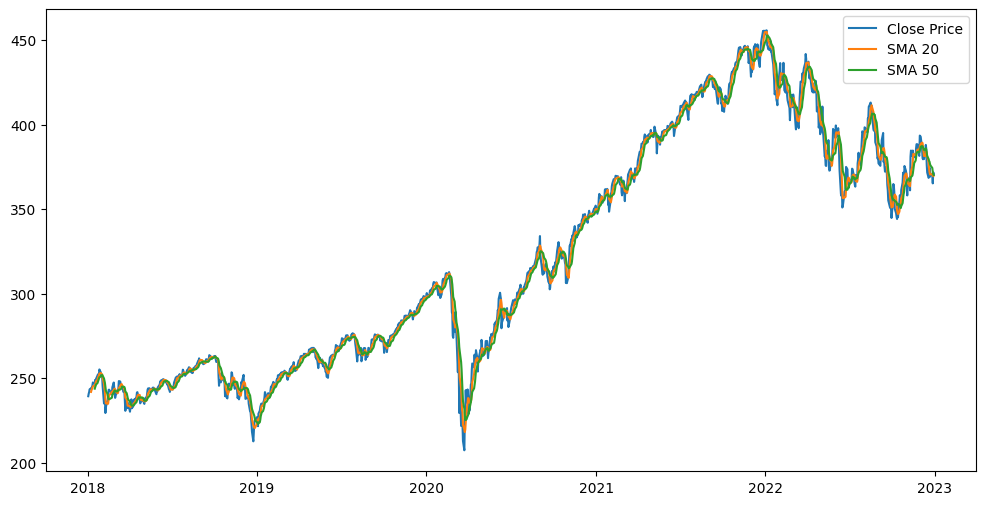

In [28]:
plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='Close Price')
plt.plot(data['SMA_short'], label='SMA 20')
plt.plot(data['SMA_long'], label='SMA 50')
plt.legend()
plt.show()

Total Buy & Hold Return: 54.98%
Total Strategy Return: 2.56%


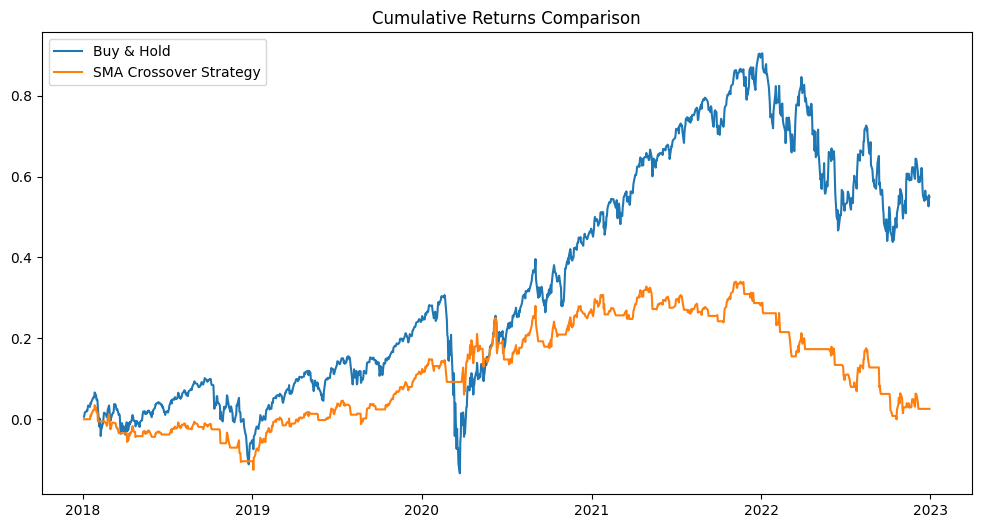

In [29]:
# Calculate daily returns of the asset
data['Market_Return'] = data['Close'].pct_change()

# Strategy return = Market return when position is 1 (holding), else 0
# We use 'Signal' shifted by 1 day because today's position affects tomorrow's returns
data['Strategy_Return'] = data['Market_Return'] * data['Signal'].shift(1)

# Calculate cumulative returns
data['Cumulative_Market_Returns'] = (1 + data['Market_Return']).cumprod() - 1
data['Cumulative_Strategy_Returns'] = (1 + data['Strategy_Return']).cumprod() - 1

# Print final returns
print(f"Total Buy & Hold Return: {data['Cumulative_Market_Returns'].iloc[-1]*100:.2f}%")
print(f"Total Strategy Return: {data['Cumulative_Strategy_Returns'].iloc[-1]*100:.2f}%")


plt.figure(figsize=(12,6))
plt.plot(data['Cumulative_Market_Returns'], label='Buy & Hold')
plt.plot(data['Cumulative_Strategy_Returns'], label='SMA Crossover Strategy')
plt.legend()
plt.title('Cumulative Returns Comparison')
plt.show()

In [30]:
# 1. Sharpe Ratio (assumes daily returns and risk-free rate = 0 for simplicity)
# Sharpe = (mean(strategy_returns) / std(strategy_returns)) * sqrt(252) for annualized
sharpe_ratio = data['Strategy_Return'].mean() / data['Strategy_Return'].std() * np.sqrt(252)

# 2. Max Drawdown
# Calculate cumulative returns
cumulative = (1 + data['Strategy_Return'].fillna(0)).cumprod()

# Running max
running_max = cumulative.cummax()

# Drawdown = (running max - current) / running max
drawdown = (running_max - cumulative) / running_max

max_drawdown = drawdown.max()

print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Max Drawdown: {max_drawdown:.4%}")

Sharpe Ratio: 0.1027
Max Drawdown: 25.4196%


In [ ]:
import pandas as pd
import numpy as np

class Backtester:
    def __init__(self, data, signals, initial_capital=100000, transaction_cost=0.001):
        """
        data: DataFrame with asset prices (must contain 'Close')
        signals: Series or DataFrame column with trading signals (1=buy, -1=sell, 0=hold)
        initial_capital: Starting money for trading
        transaction_cost: Proportional cost per trade (e.g. 0.1%)
        """
        self.data = data.copy()
        self.signals = signals
        self.initial_capital = initial_capital
        self.transaction_cost = transaction_cost

        self.positions = None
        self.trades = None
        self.portfolio = None

    def generate_positions(self):
        """
        Converts signals into positions (number of shares held).
        Assumes fully invested on long, and cash otherwise.
        """
        self.data['Signal'] = self.signals
        self.data['Position'] = 0

        # Fill forward last known signal
        self.data['Position'] = self.data['Signal'].replace(to_replace=0, method='ffill')

        # If first signal is NaN or 0, set to neutral
        self.data['Position'].fillna(0, inplace=True)
        
        # Determine shares held: capital / price when long, 0 otherwise
        self.data['Shares'] = 0
        self.data.loc[self.data['Position'] == 1, 'Shares'] = (
            self.initial_capital / self.data['Close']
        )

        self.positions = self.data[['Close', 'Position', 'Shares']]

    def simulate_trades(self):
        """
        Simulates trades and computes portfolio value over time,
        accounting for transaction costs.
        """
        data = self.data
        shares = data['Shares']
        close = data['Close']

        # Holdings: value of stocks owned
        data['Holdings'] = shares * close

        # Detect trades when signal changes (difference in position)
        data['Trade'] = data['Position'].diff().fillna(0).abs()
        
        # Transaction cost is applied only when a trade happens
        data['Transaction_Costs'] = data['Trade'] * self.transaction_cost * data['Holdings']

        # Cash starts as capital, reduced by holdings bought and costs
        data['Cash'] = self.initial_capital - (data['Holdings'].diff().fillna(0) + data['Transaction_Costs'].fillna(0)).cumsum()

        # Total portfolio value
        data['Total'] = data['Cash'] + data['Holdings']

        self.portfolio = data[['Close', 'Position', 'Shares', 'Holdings', 'Cash', 'Transaction_Costs', 'Total']]

    def calculate_performance(self):
        """
        Computes key performance metrics: return, Sharpe ratio, drawdown.
        """
        data = self.portfolio.copy()

        # Daily returns of portfolio
        data['Daily_Returns'] = data['Total'].pct_change().fillna(0)

        # Total return
        total_return = (data['Total'].iloc[-1] - self.initial_capital) / self.initial_capital

        # Sharpe ratio (assuming 252 trading days)
        sharpe_ratio = (data['Daily_Returns'].mean() / data['Daily_Returns'].std()) * np.sqrt(252)

        # Compute drawdown
        cumulative_max = data['Total'].cummax()
        drawdown = (data['Total'] - cumulative_max) / cumulative_max
        max_drawdown = drawdown.min()

        # Print metrics
        print(f"Total Return: {total_return*100:.2f}%")
        print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
        print(f"Max Drawdown: {abs(max_drawdown)*100:.2f}%")

        # Save to self for later use if needed
        self.performance = {
            "Total Return": total_return,
            "Sharpe Ratio": sharpe_ratio,
            "Max Drawdown": max_drawdown
        }

    def plot_results(self):
        data = self.portfolio.copy()

        import matplotlib.pyplot as plt

        plt.figure(figsize=(14, 7))

        # Plot portfolio value
        plt.subplot(2, 1, 1)
        plt.plot(data['Total'], label='Portfolio Value')
        plt.plot(data['Close'], label='SPY Price', alpha=0.5)
        plt.title('Portfolio Value vs SPY Price')
        plt.legend()
        plt.grid()

        # Plot buy/sell signals
        plt.subplot(2, 1, 2)
        buy_signals = data[data['Position'].diff() > 0]
        sell_signals = data[data['Position'].diff() < 0]

        plt.plot(data['Close'], label='SPY Price', alpha=0.7)
        plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='g', label='Buy Signal')
        plt.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='r', label='Sell Signal')
        plt.title('Buy/Sell Signals')
        plt.legend()
        plt.grid()

        plt.tight_layout()
        plt.show()
        
    
    def run_backtest(self):
        """
        Run the full backtest pipeline
        """
        self.generate_positions()
        self.simulate_trades()
        self.calculate_performance()
        return self.portfolio